In [1]:
#importing required python classes and packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #use to visualize dataset vallues
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import metrics 
from keras.utils.np_utils import to_categorical
from keras.layers import  MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten, RepeatVector, LSTM
from keras.layers import Convolution2D
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
import pickle
import cv2
import os

Using TensorFlow backend.
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [2]:
#function to load differnet labels found in dataset
path = "Dataset"
labels = []
X = []
Y = []
for root, dirs, directory in os.walk(path):
    for j in range(len(directory)):
        name = os.path.basename(root)
        if name not in labels:
            labels.append(name.strip())
print(labels)            

['benign', 'malignant', 'normal']


In [3]:
#function to get integer label from given label
def getLabel(name):
    index = -1
    for i in range(len(labels)):
        if labels[i] == name:
            index = i
            break
    return index

In [4]:
#load dataset image from folder
if os.path.exists("model/X.txt.npy"):
    X = np.load('model/X.txt.npy')
    Y = np.load('model/Y.txt.npy')
else:
    for root, dirs, directory in os.walk(path):#loop all images from dataset folder
        for j in range(len(directory)):
            name = os.path.basename(root)
            if 'Thumbs.db' not in directory[j]:
                if 'mask' not in directory[j]:
                    img = cv2.imread(root+"/"+directory[j])#read image
                    img = cv2.resize(img, (32, 32))#resize all images to equal sizes
                    X.append(img)
                    label = getLabel(name)#get label for given image name
                    Y.append(label)#add label and image features to X and Y array
    X = np.asarray(X)
    Y = np.asarray(Y)
    np.save('model/X.txt',X)
    np.save('model/Y.txt',Y)
print("Dataset Features Extraction & Loading Completed")
print("Total images loaded = "+str(X.shape[0]))          

Dataset Features Extraction & Loading Completed
Total images loaded = 1560


Benign : 874
Malignant : 420
Normal : 266


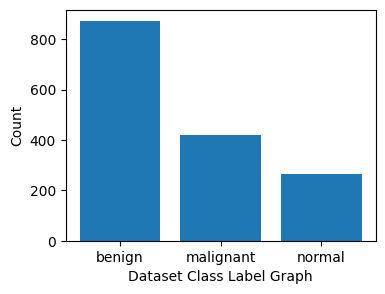

In [5]:
#finding & plotting graph of non-addicted and addicted instances
#visualizing class labels count found in dataset
label, count = np.unique(Y, return_counts = True)
print("Benign : "+str(count[0]))
print("Malignant : "+str(count[1]))
print("Normal : "+str(count[2]))
height = count
bars = labels
y_pos = np.arange(len(bars))
plt.figure(figsize = (4, 3)) 
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.xlabel("Dataset Class Label Graph")
plt.ylabel("Count")
plt.xticks()
plt.show()

In [6]:
#preprocess images like shuffling and normalization
X = X.astype('float32')
X = X/255
indices = np.arange(X.shape[0])
np.random.shuffle(indices)#shuffle all images
X = X[indices]
Y = Y[indices]
Y = to_categorical(Y)
#split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print("Dataset Image Processing & Normalization Completed")
print("80% images used to train CNN algorithm : "+str(X_train.shape[0]))
print("20% image used to train CNN algorithm : "+str(X_test.shape[0]))

Dataset Image Processing & Normalization Completed
80% images used to train CNN algorithm : 1248
20% image used to train CNN algorithm : 312


In [7]:
#define global variables to save accuracy and other metrics
accuracy = []
precision = []
recall = []
fscore = []

In [8]:
#function to calculate all metrics
def calculateMetrics(algorithm, testY, predict):
    p = precision_score(testY, predict,average='macro') * 100
    r = recall_score(testY, predict,average='macro') * 100
    f = f1_score(testY, predict,average='macro') * 100
    a = accuracy_score(testY,predict)*100
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    print(algorithm+" Accuracy  : "+str(a))
    print(algorithm+" Precision : "+str(p))
    print(algorithm+" Recall    : "+str(r))
    print(algorithm+" FSCORE    : "+str(f))
    conf_matrix = confusion_matrix(testY, predict)
    fig, axs = plt.subplots(1,2,figsize=(10, 3))
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g", ax=axs[0]);
    ax.set_ylim([0,len(labels)])
    axs[0].set_title(algorithm+" Confusion matrix") 

    random_probs = [0 for i in range(len(testY))]
    p_fpr, p_tpr, _ = roc_curve(testY, random_probs, pos_label=1)
    plt.plot(p_fpr, p_tpr, linestyle='--', color='orange',label="True classes")
    ns_tpr, ns_fpr, _ = roc_curve(testY, predict, pos_label=1)
    axs[1].plot(ns_tpr, ns_fpr, linestyle='--', label='Predicted Classes')
    axs[1].set_title(algorithm+" ROC AUC Curve")
    axs[1].set_xlabel('False Positive Rate')
    axs[1].set_ylabel('True Positive rate')
    plt.show()



CNN with Softmax Accuracy  : 98.07692307692307
CNN with Softmax Precision : 98.681493993994
CNN with Softmax Recall    : 97.38187344570322
CNN with Softmax FSCORE    : 98.01150851207633


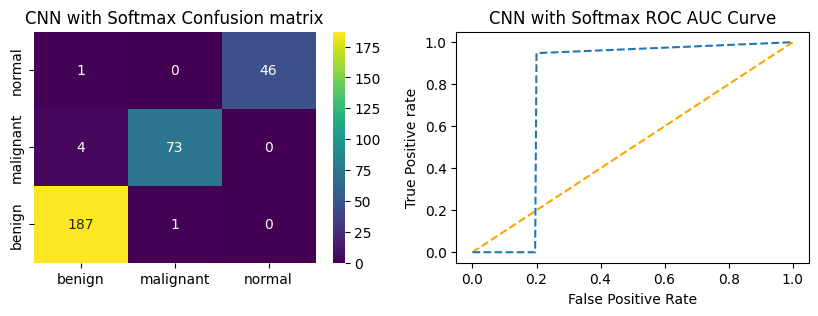

In [9]:
#ccreating CNN object
cnn_model = Sequential()
#adding CNN2d layer with 32 neurons of size 3 X 3 to filter images 32 times 
cnn_model.add(Convolution2D(32, (3 , 3), input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation = 'relu'))
#max pool layer to collect filtered relevant features from previous CNN layer
cnn_model.add(MaxPooling2D(pool_size = (2, 2)))
#adding another layer with relu activation function
#ReLU helps the first hidden layer receive errors from the last layers to adjust all weights between layers
cnn_model.add(Convolution2D(32, (3, 3), activation = 'relu'))
cnn_model.add(MaxPooling2D(pool_size = (2, 2)))
cnn_model.add(Flatten())
#adding LSTM as RNN layer
cnn_model.add(RepeatVector(2))
cnn_model.add(LSTM(32, activation = 'relu'))#==================adding RNN LSTM
#defining output layer with extra softmax layer which will divide each class prediction into probabilities and the
#class with highest probability will be best prediction and help in enhancing accuracy
cnn_model.add(Dense(units = 256, activation = 'relu'))
cnn_model.add(Dense(units = y_train.shape[1], activation = 'softmax'))
#compile the model
cnn_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
#train and load the model
if os.path.exists("model/cnn_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/cnn_weights.hdf5', verbose = 1, save_best_only = True)
    hist = cnn_model.fit(X_train, y_train, batch_size = 32, epochs = 15, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/cnn_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    cnn_model.load_weights("model/cnn_weights.hdf5")
#perform prediction on test data using cnn model   
predict = cnn_model.predict(X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)
#call this function to true test labels and predicted labels to calculate accuracy and other metrics
calculateMetrics("CNN with Softmax", y_test1, predict)

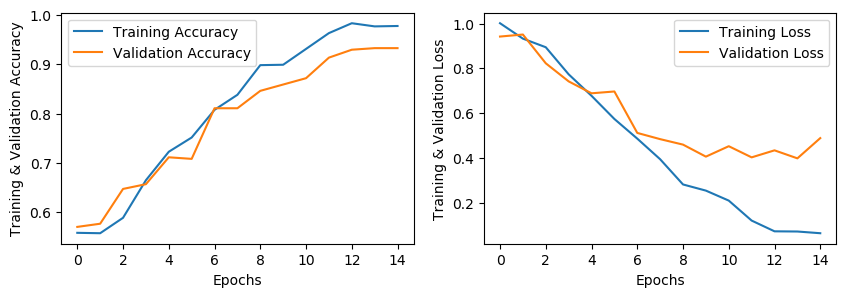

In [94]:
#plot TCN train and validation graph
def values(filename, acc, loss):
    f = open(filename, 'rb')
    train_values = pickle.load(f)
    f.close()
    accuracy_value = train_values[acc]
    loss_value = train_values[loss]
    return accuracy_value, loss_value

val_acc, val_loss = values("model/cnn_history.pckl", "val_accuracy", "val_loss")
acc, loss = values("model/cnn_history.pckl", "accuracy", "loss")    
fig, axs = plt.subplots(1,2,figsize=(10, 3))
axs[0].plot(acc)
axs[1].plot(loss)
axs[0].plot(val_acc)
axs[1].plot(val_loss)
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Training & Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Training & Validation Loss')
axs[0].legend(['Training Accuracy', 'Validation Accuracy'])
axs[1].legend(['Training Loss', 'Validation Loss'])
plt.show()

In [138]:
#function to detect disease from given test image
#use this function to predict fish species uisng extension model
def predict(image_path):
    image = cv2.imread(image_path)#read test image
    img = cv2.resize(image, (32,32))#resize image
    im2arr = np.array(img)
    im2arr = im2arr.reshape(1,32,32,3)#convert image as 4 dimension
    img = np.asarray(im2arr)
    img = img.astype('float32')#convert image features as float
    img = img/255 #normalized image
    pred = cnn_model.predict(img)#perform prediction on test image
    predicts = np.argmax(pred)
    img = cv2.imread(image_path)#read test image
    img = cv2.resize(img, (650,300))#display image with predicted output
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.putText(img, labels[predicts]+" Score "+str(np.amax(pred)), (30, 45),  cv2.FONT_HERSHEY_SIMPLEX,1.5, (0, 255, 0), 2)
    plt.figure(figsize=(6,3))
    plt.imshow(img)

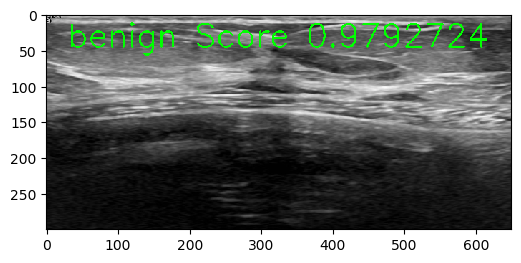

In [139]:
#call function with test image path to detect disease
predict("testImages/0.png")

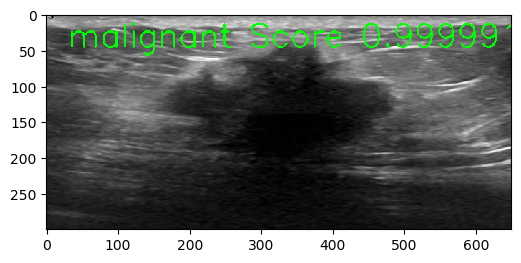

In [142]:
#call function with test image path to detect disease
predict("testImages/9.png")

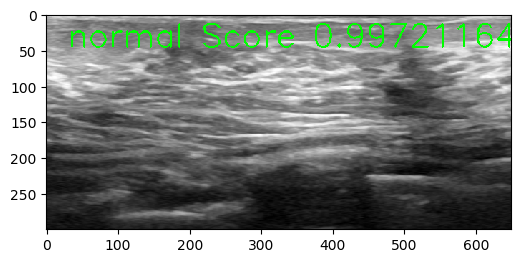

In [147]:
#call function with test image path to detect disease
predict("testImages/5.png")